In [408]:
import pandas as pd
import joblib
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')

In [409]:
df = pd.read_csv('propertycenter.csv')
df.head()

,desc,address,link,price,bedrooms,bathrooms,toilets,parking space,location
0,2 bedroom flat / apartment for rent,"Blue Waters, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,"₦13,000,000 per annum",2 Bedrooms,2 Bathrooms,2 Toilets,1 Parking Space,Lekki
1,3 bedroom flat / apartment for rent,"Banana Island, Ikoyi, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,"₦35,000,000 per annum",3 Bedrooms,3 Bathrooms,4 Toilets,2 Parking Spaces,Ikoyi
2,1 bedroom mini flat (room and parlour) for rent,"Osapa, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,"₦1,500,000 per annum",1 Bedroom,1 Bathroom,1 Toilet,1 Parking Space,Lekki
3,3 bedroom flat / apartment for rent,"Osborne, Ikoyi, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,"₦14,000,000 per annum",3 Bedrooms,3 Bathrooms,4 Toilets,Save,Ikoyi
4,2 bedroom flat / apartment for rent,"Ilasan, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,"₦6,000,000 per annum",2 Bedrooms,2 Bathrooms,3 Toilets,3 Parking Spaces,Lekki


In [410]:
data = df.copy()

<h3>Feature Engineering<h3>

In [411]:
#Just as I created a location column from address, I created a column for the area. The poor prediction ability from the data necessitated the need for this column. This is because different areas within a particular town(location) commanded different rental prices.
data['Estate'] = data['address'].apply(lambda x: x.split()[-3] +' ' + x.split()[-4] if len(x.split()) >3 else '')

In [412]:
#Column for property type derived from description column
data['ppty_type'] =data['desc'].apply(lambda x: x.split()[2] + ' ' + x.split()[3] if len(x.split()) >4 else '') 

#flat, mini flat, house, terraced duplex, semi-detached duplex, bungalow

data['ppty_type'] = data['ppty_type'].str.replace('/', '')
data['ppty_type'] = data['ppty_type'].str.replace('for', '')
data['ppty_type'].value_counts()

ppty_type
flat                      8057
terraced duplex           3344
mini flat                 2012
semi-detached duplex      1803
detached duplex           1720
                          1705
(single rooms)            1223
house                     1210
commercial property        133
complex                    122
detached bungalow           76
semi-detached bungalow      57
apartment                   52
terraced bungalow           48
meeting                     34
hotel                       31
bar                         31
 venue                      16
block of                    15
restaurant                  11
office space                 6
guest house                  3
Name: count, dtype: int64

In [413]:
data.head()

,desc,address,link,price,bedrooms,bathrooms,toilets,parking space,location,Estate,ppty_type
0,2 bedroom flat / apartment for rent,"Blue Waters, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,"₦13,000,000 per annum",2 Bedrooms,2 Bathrooms,2 Toilets,1 Parking Space,Lekki,"Waters, Blue",flat
1,3 bedroom flat / apartment for rent,"Banana Island, Ikoyi, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,"₦35,000,000 per annum",3 Bedrooms,3 Bathrooms,4 Toilets,2 Parking Spaces,Ikoyi,"Island, Banana",flat
2,1 bedroom mini flat (room and parlour) for rent,"Osapa, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,"₦1,500,000 per annum",1 Bedroom,1 Bathroom,1 Toilet,1 Parking Space,Lekki,,mini flat
3,3 bedroom flat / apartment for rent,"Osborne, Ikoyi, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,"₦14,000,000 per annum",3 Bedrooms,3 Bathrooms,4 Toilets,Save,Ikoyi,,flat
4,2 bedroom flat / apartment for rent,"Ilasan, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,"₦6,000,000 per annum",2 Bedrooms,2 Bathrooms,3 Toilets,3 Parking Spaces,Lekki,,flat


In [414]:

data['Estate'].unique()

array(['Waters, Blue', 'Island, Banana', '', ..., 'Cele, Way,',
       'Estate,, Layout', 'Mall, Purple'], dtype=object)

In [415]:
df['desc'].unique()

array(['2 bedroom flat / apartment for rent',
       '3 bedroom flat / apartment for rent',
       '1 bedroom mini flat (room and parlour) for rent',
       '5 bedroom house for rent', '4 bedroom terraced duplex for rent',
       '3 bedroom terraced duplex for rent', 'Shop for rent',
       '3 bedroom house for rent', '6 bedroom detached duplex for rent',
       '4 bedroom semi-detached duplex for rent',
       '5 bedroom semi-detached duplex for rent',
       '1 bedroom flat / apartment for rent',
       '5 bedroom detached duplex for rent',
       '2 bedroom terraced duplex for rent',
       'Self contain (single rooms) for rent', '2 bedroom house for rent',
       '10 bedroom detached duplex for rent',
       '6 bedroom flat / apartment for rent',
       '4 bedroom detached duplex for rent',
       '5 bedroom terraced duplex for rent',
       'Commercial property for rent', '4 bedroom house for rent',
       'Office space for rent', '3 bedroom semi-detached duplex for rent',
       

In [416]:
data['bathrooms'].unique()

array(['2 Bathrooms', '3 Bathrooms', '1 Bathroom', '5 Bathrooms',
       '4 Bathrooms', 'Save', '6 Bathrooms', '1 Toilet', '2 Toilets',
       '3 Toilets', '4 Toilets', '7 Bathrooms', '500 sqm Total Area',
       '5 Toilets', '10 Bathrooms', '28 sqm Covered Area',
       '20 Parking Spaces', '1,000 sqm Covered Area', '6 Toilets',
       '7 Toilets', '10 Parking Spaces', '2 Parking Spaces',
       '3 Parking Spaces', '400 sqm Total Area', '22 Bathrooms',
       '8 Bathrooms', '12 Bathrooms', '1 Parking Space',
       '5 Parking Spaces', '9 Bathrooms', '600 sqm Total Area',
       '6 Parking Spaces', '322 sqm Covered Area', '65 sqm Total Area',
       '20 Bathrooms', '25 Bathrooms', '2,828 sqm Covered Area',
       '2,000 sqm Total Area', '32 Bathrooms', '120 sqm Total Area',
       '332 sqm Covered Area', '300 sqm Total Area', '8 Toilets',
       '16 Toilets', '10 Toilets', '104 sqm Covered Area',
       '460 sqm Total Area', '1,900 sqm Covered Area',
       '750 sqm Total Area', '100 s

In [417]:
data.shape

(21709, 11)

In [418]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21709 entries, 0 to 21708
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   desc           21709 non-null  object
 1   address        21709 non-null  object
 2   link           21709 non-null  object
 3   price          21709 non-null  object
 4   bedrooms       20905 non-null  object
 5   bathrooms      21709 non-null  object
 6   toilets        21709 non-null  object
 7   parking space  20554 non-null  object
 8   location       21709 non-null  object
 9   Estate         21709 non-null  object
 10  ppty_type      21709 non-null  object
dtypes: object(11)
memory usage: 1.8+ MB


<h3><h2>Data Cleaning<h1>

In [419]:
# the initial copied data included properties for other uses such as warehouses and tank farms. These data points were dropped from this analysis.
target = ['Warehouse', 'Tank', 'Commercial', 'Office', 'Plaza', 'complex', 'hotel', 'guest', 'Hall', 'shop' ]
mask = data['desc'].str.contains('|'.join(target))
data = data.drop(df[mask].index)            

In [420]:
#cleaned the price column to have a numeric data
data.price = data.price.str.replace('₦', '')
data.price = data.price.str.replace('per annum', '')
data.price = data.price.str.replace(',', '')
data.price = pd.to_numeric(data.price, errors = 'coerce')
data.price

0        13000000.0
1        35000000.0
2         1500000.0
3        14000000.0
4         6000000.0
            ...    
21704     5500000.0
21705    15000000.0
21706     6500000.0
21707    15000000.0
21708     6500000.0
Name: price, Length: 20214, dtype: float64

In [421]:
data.isnull().sum()

desc               0
address            0
link               0
price            393
bedrooms         334
bathrooms          0
toilets            0
parking space    875
location           0
Estate             0
ppty_type          0
dtype: int64

In [422]:
#removed null values and replaced categorical data points with mode of column and numeric data with median. This will probably introduce acceptable errors
for i in data.columns:
    if ((data[i].isnull().sum()/len(data[i]))*100) < 30:
        if data[i].dtype != 'O':
            data[i].fillna(data[i].median(), inplace = True)
        else:
            data[i].fillna(data[i].mode()[0], inplace = True)
    else:
        data.drop(i, axis = 1, inplace = True)



In [423]:
data.isnull().sum()

desc             0
address          0
link             0
price            0
bedrooms         0
bathrooms        0
toilets          0
parking space    0
location         0
Estate           0
ppty_type        0
dtype: int64

In [424]:
# the data showed that the scraping created some errors because some columns data points were found in columns preceidng theirs. Hence there was the need to move the data values into their rightful columns
mask = data['bedrooms'].str.contains('Bathroom') 
mask1 = data['bedrooms'].str.contains('Toilet')
mask2 = data['bedrooms'].str.contains('Parking Space')
data.loc[mask, 'bathrooms'] = data.loc[mask, 'bedrooms']
data.loc[mask1, 'toilets'] = data.loc[mask, 'bedrooms'] 
data.loc[mask2, 'parking space'] = data.loc[mask, 'bedrooms'] 

In [425]:
mask = data['bathrooms'].str.contains('Toilet')
mask2 = data['bathrooms'].str.contains('Parking Space')
data.loc[mask, 'toilets'] = data.loc[mask, 'bathrooms'] 
data.loc[mask2, 'parking space'] = data.loc[mask, 'bathrooms'] 

In [426]:
data.isnull().sum()

desc               0
address            0
link               0
price              0
bedrooms           0
bathrooms          0
toilets          150
parking space     62
location           0
Estate             0
ppty_type          0
dtype: int64

In [427]:
#removal of empty rows created as a result of movement of data from one column to another
data.dropna(inplace= True)

In [428]:
data.isnull().sum()

desc             0
address          0
link             0
price            0
bedrooms         0
bathrooms        0
toilets          0
parking space    0
location         0
Estate           0
ppty_type        0
dtype: int64

In [429]:
data.shape

(20025, 11)

In [430]:
data.dropna(inplace= True)

In [431]:
mask = data['toilets'].str.contains('Parking Space')
data.loc[mask, 'parking space'] = data.loc[mask, 'toilets'] 

In [432]:
data.isnull().sum()

desc             0
address          0
link             0
price            0
bedrooms         0
bathrooms        0
toilets          0
parking space    0
location         0
Estate           0
ppty_type        0
dtype: int64

In [433]:
#bedroom columns still had some features that include that of warehouse and lands
data['bedrooms'].unique()

array(['2 Bedrooms', '3 Bedrooms', '1 Bedroom', '5 Bedrooms',
       '4 Bedrooms', '6 Bedrooms', '1 Bathroom', '10 Bedrooms',
       '7 Bedrooms', '3 Bathrooms', '8 Bedrooms', '22 Bedrooms',
       '9 Bedrooms', '11 Bedrooms', '50 Bedrooms', '520 sqm Total Area',
       '180 sqm Total Area', '20 Bedrooms', '550 sqm Total Area',
       '32 Bedrooms', '2 Bathrooms', '332 sqm Total Area',
       '1,900 sqm Total Area', '17 Bedrooms', '350 sqm Total Area',
       '36 Bedrooms', '12 Bedrooms', '4,029 sqm Total Area',
       '16 Bedrooms', '15 Bedrooms', '1,000 sqm Total Area',
       '31 Bedrooms', '2,000 sqm Total Area', '18 Bedrooms',
       '200 sqm Covered Area', '25 sqm Total Area', '500 sqm Total Area',
       '24 sqm Total Area', '420 sqm Total Area', '100 sqm Covered Area',
       '96 Bedrooms', '14 Bedrooms', '1,687 sqm Total Area',
       '120 sqm Total Area', '13 Bedrooms', '90 sqm Covered Area',
       '250 sqm Total Area', '19 Bedrooms', '4 Bathrooms', '9 Bathrooms',
       '63

In [434]:
#Code takes only values that have bedrooms
data['bedrooms'] = data['bedrooms'].apply(lambda x: x if ('Bedroom') in x else '')

In [435]:
data['bedrooms'].unique()

array(['2 Bedrooms', '3 Bedrooms', '1 Bedroom', '5 Bedrooms',
       '4 Bedrooms', '6 Bedrooms', '', '10 Bedrooms', '7 Bedrooms',
       '8 Bedrooms', '22 Bedrooms', '9 Bedrooms', '11 Bedrooms',
       '50 Bedrooms', '20 Bedrooms', '32 Bedrooms', '17 Bedrooms',
       '36 Bedrooms', '12 Bedrooms', '16 Bedrooms', '15 Bedrooms',
       '31 Bedrooms', '18 Bedrooms', '96 Bedrooms', '14 Bedrooms',
       '13 Bedrooms', '19 Bedrooms', '33 Bedrooms', '56 Bedrooms',
       '28 Bedrooms', '52 Bedrooms', '72 Bedrooms', '39 Bedrooms',
       '24 Bedrooms', '21 Bedrooms', '35 Bedrooms', '37 Bedrooms'],
      dtype=object)

In [436]:
#Same process as above to remove unwanted data values
data.bathrooms.unique()

array(['2 Bathrooms', '3 Bathrooms', '1 Bathroom', '5 Bathrooms',
       '4 Bathrooms', 'Save', '6 Bathrooms', '2 Toilets', '1 Toilet',
       '4 Toilets', '7 Bathrooms', '3 Toilets', '5 Toilets',
       '10 Bathrooms', '6 Toilets', '7 Toilets', '22 Bathrooms',
       '8 Bathrooms', '12 Bathrooms', '9 Bathrooms', '20 Bathrooms',
       '32 Bathrooms', '332 sqm Covered Area', '1,900 sqm Covered Area',
       '17 Bathrooms', '16 Bathrooms', '36 Bathrooms', '43 Bathrooms',
       '15 Bathrooms', '14 Bathrooms', '25 sqm Covered Area',
       '11 Bathrooms', '48 Bathrooms', '13 Bathrooms',
       '200 sqm Covered Area', '25 Bathrooms', '90 Bathrooms',
       '18 Bathrooms', '45 Toilets', '500 Bathrooms',
       '630 sqm Covered Area', '33 Bathrooms', '56 Bathrooms',
       '500 sqm Covered Area', '15 Toilets', '28 Bathrooms',
       '23 Bathrooms', '322 sqm Covered Area', '287 Bathrooms',
       '180 sqm Covered Area', '900 sqm Total Area', '14 Toilets',
       '350 sqm Covered Area', '24 B

In [437]:
data['bathrooms'] = data['bathrooms'].apply(lambda x: x if ('Bathroom') in x else '')

In [438]:
data.bathrooms.unique()

array(['2 Bathrooms', '3 Bathrooms', '1 Bathroom', '5 Bathrooms',
       '4 Bathrooms', '', '6 Bathrooms', '7 Bathrooms', '10 Bathrooms',
       '22 Bathrooms', '8 Bathrooms', '12 Bathrooms', '9 Bathrooms',
       '20 Bathrooms', '32 Bathrooms', '17 Bathrooms', '16 Bathrooms',
       '36 Bathrooms', '43 Bathrooms', '15 Bathrooms', '14 Bathrooms',
       '11 Bathrooms', '48 Bathrooms', '13 Bathrooms', '25 Bathrooms',
       '90 Bathrooms', '18 Bathrooms', '500 Bathrooms', '33 Bathrooms',
       '56 Bathrooms', '28 Bathrooms', '23 Bathrooms', '287 Bathrooms',
       '24 Bathrooms', '72 Bathrooms', '39 Bathrooms', '21 Bathrooms',
       '45 Bathrooms', '37 Bathrooms', '400 Bathrooms', '40 Bathrooms',
       '38 Bathrooms'], dtype=object)

In [439]:
#Same to toilets
data['toilets'] = data['toilets'].apply(lambda x: x if ('Toilet') in x else '')

In [440]:
data['toilets'].unique()

array(['2 Toilets', '4 Toilets', '1 Toilet', '3 Toilets', '6 Toilets',
       '5 Toilets', '', '7 Toilets', '8 Toilets', '11 Toilets',
       '29 Toilets', '13 Toilets', '12 Toilets', '9 Toilets',
       '20 Toilets', '40 Toilets', '23 Toilets', '48 Toilets',
       '18 Toilets', '10 Toilets', '17 Toilets', '15 Toilets',
       '22 Toilets', '32 Toilets', '16 Toilets', '36 Toilets',
       '46 Toilets', '14 Toilets', '25 Toilets', '100 Toilets',
       '45 Toilets', '38 Toilets', '33 Toilets', '66 Toilets',
       '30 Toilets', '24 Toilets', '21 Toilets', '44 Toilets',
       '96 Toilets', '55 Toilets', '65 Toilets', '26 Toilets',
       '47 Toilets'], dtype=object)

In [441]:
#Same to parking space
data['parking space'] = data['parking space'].apply(lambda x: x if ('Parking Space') in x else '')

In [442]:
data['parking space'].unique()

array(['1 Parking Space', '2 Parking Spaces', '', '3 Parking Spaces',
       '4 Parking Spaces', '12 Parking Spaces', '5 Parking Spaces',
       '6 Parking Spaces', '20 Parking Spaces', '9 Parking Spaces',
       '8 Parking Spaces', '10 Parking Spaces', '7 Parking Spaces',
       '500 Parking Spaces', '28 Parking Spaces', '11 Parking Spaces',
       '25 Parking Spaces', '15 Parking Spaces', '16 Parking Spaces',
       '18 Parking Spaces', '50 Parking Spaces', '13 Parking Spaces',
       '30 Parking Spaces', '32 Parking Spaces', '60 Parking Spaces',
       '35 Parking Spaces', '45 Parking Spaces', '1000 Parking Spaces',
       '24 Parking Spaces', '23 Parking Spaces', '250 Parking Spaces',
       '14 Parking Spaces', '80 Parking Spaces', '40 Parking Spaces',
       '300 Parking Spaces', '120 Parking Spaces', '150 Parking Spaces',
       '100 Parking Spaces', '200 Parking Spaces', '22 Parking Spaces',
       '5000 Parking Spaces', '600 Parking Spaces', '70 Parking Spaces',
       '52 Par

In [443]:
#code to get only the number of bedrroms by splitting the data value and taking value at index 0
data.bedrooms = data.bedrooms.apply(lambda x: str(x))
data.bedrooms = data.bedrooms.str.split(pat = ' ', expand = True )[0]
data['bedrooms']= pd.to_numeric(data['bedrooms'], errors='coerce').round(2)
data.bedrooms.unique()

array([ 2.,  3.,  1.,  5.,  4.,  6., nan, 10.,  7.,  8., 22.,  9., 11.,
       50., 20., 32., 17., 36., 12., 16., 15., 31., 18., 96., 14., 13.,
       19., 33., 56., 28., 52., 72., 39., 24., 21., 35., 37.])

In [444]:
data['bedrooms'].value_counts()

bedrooms
4.0     5654
3.0     4878
2.0     3874
1.0     2454
5.0     1570
6.0      206
10.0      41
7.0       36
8.0       20
12.0      12
9.0        9
11.0       8
13.0       6
15.0       6
20.0       6
16.0       5
32.0       4
22.0       4
37.0       3
24.0       3
17.0       3
18.0       2
28.0       1
35.0       1
21.0       1
39.0       1
72.0       1
52.0       1
36.0       1
56.0       1
19.0       1
14.0       1
96.0       1
31.0       1
50.0       1
33.0       1
Name: count, dtype: int64

In [445]:
#same as above
data.bathrooms = data.bathrooms.apply(lambda x: str(x))
data.bathrooms = data.bathrooms.str.split(pat = ' ', expand = True )[0]
data['bathrooms']= pd.to_numeric(data['bathrooms'], errors='coerce').round(2)
data.bathrooms.unique()

array([  2.,   3.,   1.,   5.,   4.,  nan,   6.,   7.,  10.,  22.,   8.,
        12.,   9.,  20.,  32.,  17.,  16.,  36.,  43.,  15.,  14.,  11.,
        48.,  13.,  25.,  90.,  18., 500.,  33.,  56.,  28.,  23., 287.,
        24.,  72.,  39.,  21.,  45.,  37., 400.,  40.,  38.])

In [446]:
#same as above
data.toilets = data.toilets.apply(lambda x: str(x))
data.toilets = data.toilets.str.split(pat = ' ', expand = True )[0]
data.toilets = pd.to_numeric(data.toilets, errors='coerce').round(2)
data.toilets.unique()

array([  2.,   4.,   1.,   3.,   6.,   5.,  nan,   7.,   8.,  11.,  29.,
        13.,  12.,   9.,  20.,  40.,  23.,  48.,  18.,  10.,  17.,  15.,
        22.,  32.,  16.,  36.,  46.,  14.,  25., 100.,  45.,  38.,  33.,
        66.,  30.,  24.,  21.,  44.,  96.,  55.,  65.,  26.,  47.])

In [447]:
#Same as above
data['parking space'] = data['parking space'].apply(lambda x: str(x))
data['parking space'] = data['parking space'].str.split(pat = ' ', expand = True )[0]
data['parking space']= pd.to_numeric(data['parking space'], errors='coerce').round(2)
data['parking space'].unique()

array([1.0e+00, 2.0e+00,     nan, 3.0e+00, 4.0e+00, 1.2e+01, 5.0e+00,
       6.0e+00, 2.0e+01, 9.0e+00, 8.0e+00, 1.0e+01, 7.0e+00, 5.0e+02,
       2.8e+01, 1.1e+01, 2.5e+01, 1.5e+01, 1.6e+01, 1.8e+01, 5.0e+01,
       1.3e+01, 3.0e+01, 3.2e+01, 6.0e+01, 3.5e+01, 4.5e+01, 1.0e+03,
       2.4e+01, 2.3e+01, 2.5e+02, 1.4e+01, 8.0e+01, 4.0e+01, 3.0e+02,
       1.2e+02, 1.5e+02, 1.0e+02, 2.0e+02, 2.2e+01, 5.0e+03, 6.0e+02,
       7.0e+01, 5.2e+01, 5.4e+01, 1.7e+01, 8.0e+02, 6.5e+01, 2.1e+01])

In [448]:
#New empty rows created as a result of the above processes were dropped
data.isnull().sum()

desc                0
address             0
link                0
price               0
bedrooms         1207
bathrooms        2229
toilets          2961
parking space    8476
location            0
Estate              0
ppty_type           0
dtype: int64

In [449]:
data.dropna(inplace= True)

In [450]:
data.isnull().sum()

desc             0
address          0
link             0
price            0
bedrooms         0
bathrooms        0
toilets          0
parking space    0
location         0
Estate           0
ppty_type        0
dtype: int64

In [451]:
data.shape

(10725, 11)

In [452]:
data.tail(20)

,desc,address,link,price,bedrooms,bathrooms,toilets,parking space,location,Estate,ppty_type
21680,4 bedroom terraced duplex for rent,"Ikoyi, Lagos",https://nigeriapropertycentre.com//for-rent/ho...,15000000.0,4.0,4.0,5.0,12.0,Ikoyi,,terraced duplex
21681,4 bedroom terraced duplex for rent,"Ikoyi, Lagos",https://nigeriapropertycentre.com//for-rent/ho...,15000000.0,4.0,4.0,5.0,12.0,Ikoyi,,terraced duplex
21683,2 bedroom flat / apartment for rent,"Blue Waters, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,13000000.0,2.0,2.0,2.0,1.0,Lekki,"Waters, Blue",flat
21685,2 bedroom flat / apartment for rent,"Blue Waters, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,13000000.0,2.0,2.0,2.0,1.0,Lekki,"Waters, Blue",flat
21686,1 bedroom mini flat (room and parlour) for rent,"Off Admiralty, Lekki Phase 1, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,5500000.0,1.0,1.0,1.0,1.0,Lekki,"1, Phase",mini flat
21688,2 bedroom flat / apartment for rent,"Blue Waters, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,13000000.0,2.0,2.0,2.0,1.0,Lekki,"Waters, Blue",flat
21689,1 bedroom mini flat (room and parlour) for rent,"Off Admiralty, Lekki Phase 1, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,5500000.0,1.0,1.0,1.0,1.0,Lekki,"1, Phase",mini flat
21690,4 bedroom terraced duplex for rent,"Ikoyi, Lagos",https://nigeriapropertycentre.com//for-rent/ho...,15000000.0,4.0,4.0,5.0,12.0,Ikoyi,,terraced duplex
21691,2 bedroom flat / apartment for rent,"Blue Waters, Lekki, Lagos",https://nigeriapropertycentre.com//for-rent/fl...,13000000.0,2.0,2.0,2.0,1.0,Lekki,"Waters, Blue",flat
21692,4 bedroom terraced duplex for rent,"Ikoyi, Lagos",https://nigeriapropertycentre.com//for-rent/ho...,15000000.0,4.0,4.0,5.0,12.0,Ikoyi,,terraced duplex


<h3><h2>Removing Outliers<h1>
<h5>The initial prediction test was low because of the presence of a lot of outliers like houses with 60 rooms, and those with unrealistic prices that most likely are erroneous. Hence, it is important that I remove outliers from the different affected columns. Hence, using varying quantiles for outlier removals,  our feauture parameters are limited to 5 bedrooms, 5 bathrooms, 5 toilets, 4 parking spaces and max price of N30m <h5>

In [453]:
bedrooms_max = data['bedrooms'].quantile(0.97)
bedrooms_max

5.0

In [454]:
data = data[data['bedrooms'] <bedrooms_max]

In [455]:
bathroom_max = data['bathrooms'].quantile(0.97)
bathroom_max

5.0

In [456]:
data = data[data['bathrooms']<bathroom_max]

In [457]:
toilet_max = data['toilets'].quantile(0.97)
toilet_max

5.0

In [458]:
data = data[data['toilets']<toilet_max]

In [459]:
parking_max = data['parking space'].quantile(0.80)
parking_max

4.0

In [460]:
data = data[data['parking space']<parking_max]

In [461]:
data['price'].describe().round(12)

count    5.274000e+03
mean     9.671601e+06
std      1.431457e+08
min      1.000000e+05
25%      2.500000e+06
50%      4.500000e+06
75%      8.000000e+06
max      1.000000e+10
Name: price, dtype: float64

In [462]:
price_max = data['price'].quantile(0.98)
price_max

30000000.0

In [463]:
data = data[data['price']<price_max]

In [464]:
data.describe()

,price,bedrooms,bathrooms,toilets,parking space
count,5.127000e+03,5127.000000,5127.000000,5127.000000,5127.000000
mean,5.924588e+06,2.224108,2.283792,2.947143,1.906183
std,5.191861e+06,0.818187,0.844537,1.014398,0.654805
min,1.000000e+05,1.000000,1.000000,1.000000,1.000000
25%,2.300000e+06,2.000000,2.000000,2.000000,1.000000
50%,4.000000e+06,2.000000,2.000000,3.000000,2.000000
75%,7.500000e+06,3.000000,3.000000,4.000000,2.000000
max,2.801000e+07,4.000000,4.000000,4.000000,3.000000


<h3><h2>Data Visualization<h1>

In [465]:
def plotter(data, col1, col2, col3, col4, dep):
    sns.set(style = 'darkgrid')
    plt.figure(figsize=(20,6))

    plt.subplot(1, 4, 1)
    sns.regplot(data=data, x= col1, y = dep)
    plt.title(f'Relationship btw {col1} and {dep} is {(data[dep].corr(data[col1])*100).round(2)}')

    plt.subplot(1, 4, 2)
    sns.regplot(data=data, x= col2, y = dep)
    plt.title(f'Relationship btw {col2} and {dep} is {(data[dep].corr(data[col2])*100).round(2)}')

    plt.subplot(1, 4, 3)
    sns.regplot(data=data, x= col3, y = dep)
    plt.title(f'Relationship btw {col3} and {dep} is {(data[dep].corr(data[col3])*100).round(2)}')

    plt.subplot(1, 4, 4)
    sns.regplot(data=data, x= col4, y = dep)
    plt.title(f'Relationship btw {col4} and {dep} is {(data[dep].corr(data[col4])*100).round(2)}')

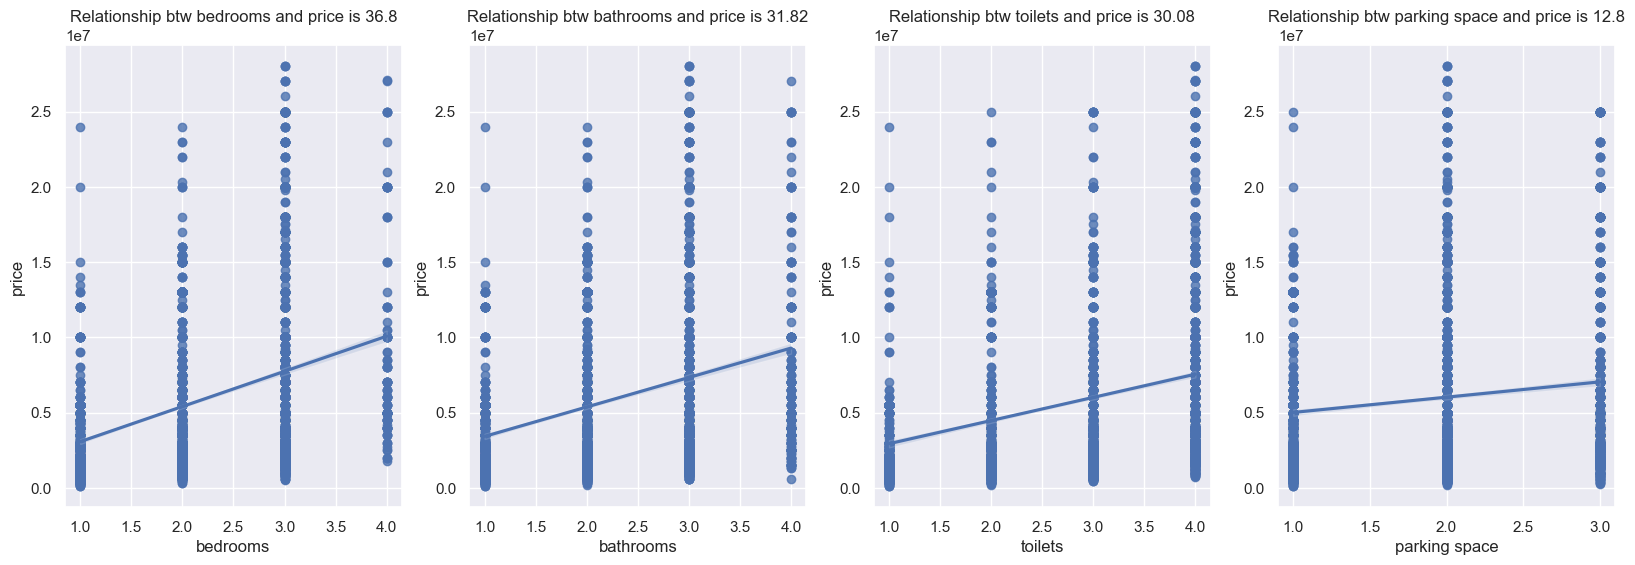

In [466]:
plotter(data, 'bedrooms', 'bathrooms', 'toilets', 'parking space','price')

Text(0.5, 1.0, 'Price VS Location')

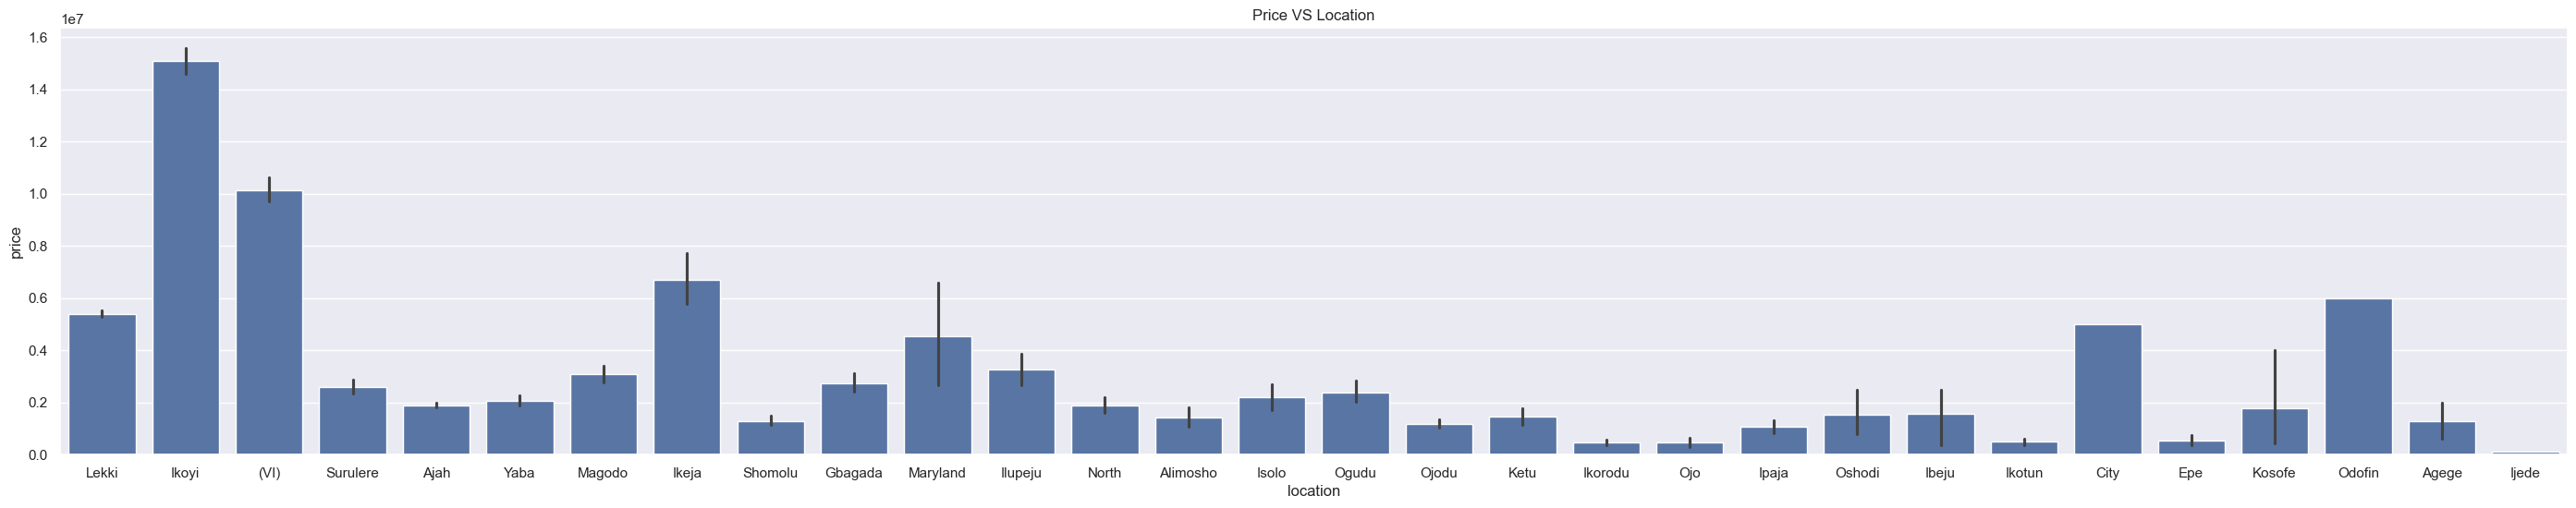

In [467]:
sns.set(style = 'darkgrid')
plt.figure(figsize=(35,6))
sns.barplot(data= data, x= data['location'], y = data['price'])
plt.title(f'Price VS Location')

Text(0.5, 1.0, 'Price VS ppty_type')

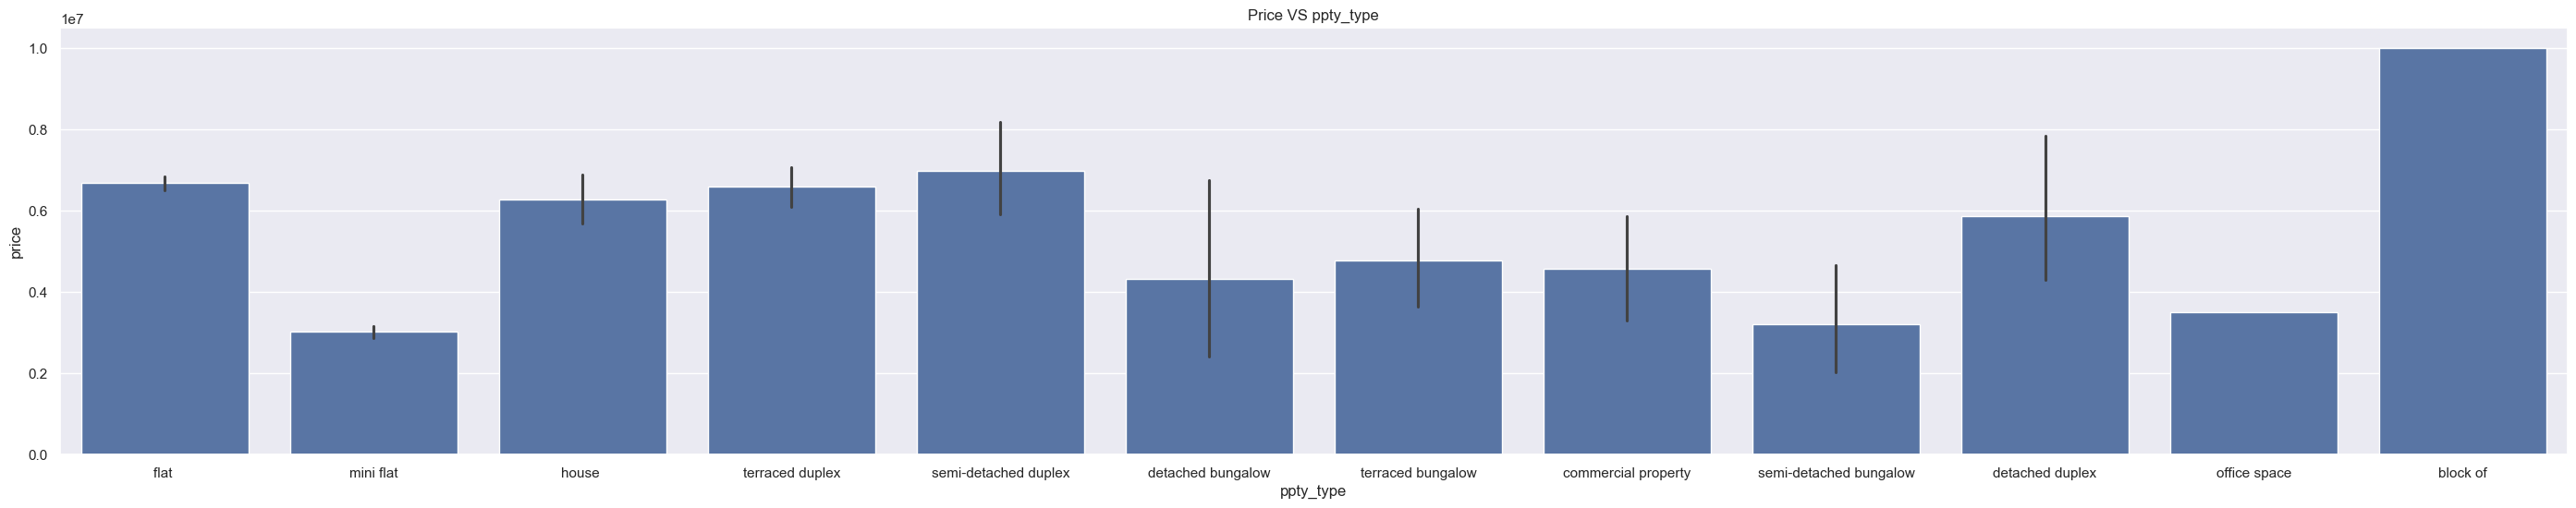

In [468]:
sns.set(style = 'darkgrid')
plt.figure(figsize=(35,6))
sns.barplot(data= data, x= data['ppty_type'], y = data['price'])
plt.title(f'Price VS ppty_type')

<h3>Encoding of Categorical data to numerical data using the labelencoder<h3>

In [469]:
encoder = LabelEncoder()
data.location = encoder.fit_transform(data.location)
joblib.dump(encoder, open('location.encoder.pkl', 'wb'))

In [470]:
encoder = LabelEncoder()
data['Estate'] = encoder.fit_transform(data.Estate)
joblib.dump(encoder, open('Estate.encoder.pkl', 'wb'))

In [471]:
encoder = LabelEncoder()
data['ppty_type'] = encoder.fit_transform(data.ppty_type)
joblib.dump(encoder, open('ppty_type.encoder.pkl', 'wb'))

<h3>Feature Selection: - Using the xgboost, to determine relevant feaures<h3>

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

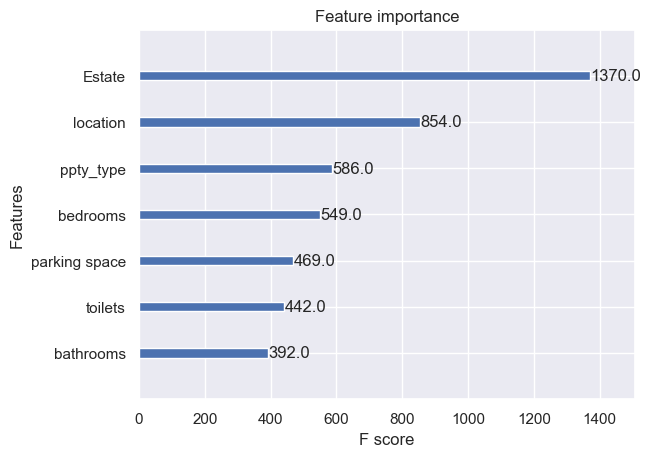

In [472]:
x= data.drop(['price','desc', 'address','link'], axis = 1)
y = data['price']

model = xgb.XGBRegressor()
model.fit(x,y)

xgb.plot_importance(model, importance_type='weight')

<h3> Split my dataset to train and test. I also dropped irrelevant columns which include the parking space despite its relevance highlighted above..This is because of domain knowledge, the erronous inputs noticed on the website and its effect on the predictions<h3>

In [531]:
x= data.drop(['price','desc', 'parking space','address','link'], axis = 1)
y = data['price']

xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=0.20, random_state= 1000)

display(xtrain.shape)
display(xtest.shape)
display(ytrain.shape)
display(ytest.shape)

(4101, 6)

(1026, 6)

(4101,)

(1026,)

<h3>Used Three different ML models <h3>

In [541]:
model_lin = LinearRegression()
model_rfn = RandomForestRegressor(n_estimators=100)
model_xgb = xgb.XGBRegressor()

In [542]:
model_lin.fit(xtrain, ytrain)
model_rfn.fit(xtrain, ytrain)
model_xgb.fit(xtrain, ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<h3>Cross Validated the data using the xtrain and comparing it to ytrain. Random Forest And xgboost gave relatively better results<h3>

In [543]:
cross_validation = model_lin.predict(xtrain)
score = r2_score(ytrain, cross_validation)
score

0.16140798683930035

In [544]:
cross_validation = model_rfn.predict(xtrain)
score = r2_score(ytrain, cross_validation)
score

0.8044765557234933

In [545]:
cross_validation = model_xgb.predict(xtrain)
score = r2_score(ytrain, cross_validation)
score

0.8036444045553413

<h3>Results on the test data however shows that the xgboost has the better result of the two with 71.8 r2_score and hence adopted<h3>

In [546]:
ypred1 = model_rfn.predict(xtest)
score = r2_score(ytest, ypred1)
score

0.7424649136232055

In [547]:
ypred = model_xgb.predict(xtest)
score = r2_score(ytest, ypred)
score

0.7370270028366112

In [548]:
#models saved to joblib
model = joblib.load('location.encoder.pkl')
model1 = joblib.load('Estate.encoder.pkl')
model3 = joblib.load('ppty_type.encoder.pkl')
model2 =joblib.dump(model_xgb, open('model_xgb.pkl', 'wb'))
model4 =joblib.dump(model_rfn, open('model_rfn.pkl', 'wb'))

<h3>A data frame was created, to compare the ypred and the actual<h3>

In [549]:
compare = pd.DataFrame()
compare['Bedrooms'] = xtest['bedrooms']
compare['location'] = model.inverse_transform(xtest['location'])
compare['Estate'] = model1.inverse_transform(xtest['Estate'])
compare['ppty_type'] = model3.inverse_transform(xtest['ppty_type'])
compare['actual'] = ytest
compare['predicted'] = np.ceil(ypred1.round(2))

compare.tail()

,Bedrooms,location,Estate,ppty_type,actual,predicted
1851,1.0,Yaba,"Quarters, Yabatech",mini flat,1500000.0,1784000.0
20916,2.0,Lekki,"Waters, Blue",flat,13000000.0,13000000.0
9602,3.0,Ikoyi,,flat,20000000.0,14142333.0
17767,2.0,Lekki,"Elegushi, Ikate",flat,3500000.0,6257728.0
13767,2.0,North,,flat,2500000.0,2686018.0
